<a href="https://colab.research.google.com/github/yiit8/object-detection-/blob/main/Car_Object_Detection_Initial_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# install libraries/packages/modules 

!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install timm
!pip install --upgrade opencv-contrib-python

In [2]:
! pip install -q kaggle

from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"yigitgun","key":"49c2c5fd9b39e87cdeb94cc886d4ec78"}'}

In [5]:
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [6]:
! kaggle datasets download "sshikamaru/car-object-detection"

 83% 93.0M/112M [00:04<00:00, 20.0MB/s]
100% 112M/112M [00:04<00:00, 28.1MB/s] 


In [ ]:
! unzip "/content/car-object-detection.zip" -d "/content/car-object-detection"

In [8]:
# Imports

import pandas as pd 
import numpy as np 
import cv2
import matplotlib.pyplot as plt
import torch
from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [9]:
import sys
sys.path.append('/content/car-object-detection')

In [10]:
csv_file = '/content/car-object-detection/data/train_solution_bounding_boxes (1).csv'

data_dir = '/content/car-object-detection/data/training_images/'

device = 'cuda'

batch_size = 16

img_size = 240

lr = 0.001

epochs = 30

num_cor = 4

model_name = 'vgg19'

In [11]:
df = pd.read_csv(csv_file)

df

,image,xmin,ymin,xmax,ymax
0,vid_4_1000.jpg,281.259045,187.035071,327.727931,223.225547
1,vid_4_10000.jpg,15.163531,187.035071,120.329957,236.430180
2,vid_4_10040.jpg,239.192475,176.764801,361.968162,236.430180
3,vid_4_10020.jpg,496.483358,172.363256,630.020260,231.539575
4,vid_4_10060.jpg,16.630970,186.546010,132.558611,238.386422
...,...,...,...,...,...
554,vid_4_9860.jpg,0.000000,198.321729,49.235251,236.223284
555,vid_4_9880.jpg,329.876184,156.482351,536.664239,250.497895
556,vid_4_9900.jpg,0.000000,168.295823,141.797524,239.176652
557,vid_4_9960.jpg,487.428988,172.233646,616.917699,228.839864


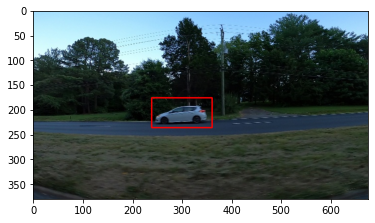

In [12]:
# Single observation to understand the dataset
row = df.iloc[2]

img = cv2.imread(data_dir + row['image'])

img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

pt1 = (row.xmin, row.ymin)

pt2 = (row.xmax, row.ymax)

bnd_box_img = cv2.rectangle(img, (int(pt1[0]),int(pt1[1])), (int(pt2[0]),int(pt2[1])), (255, 0, 0), 2)

plt.imshow(bnd_box_img)

In [13]:
# Splitting data to train - valid sets

train_df, valid_df = train_test_split(df, test_size = 0.25, random_state = 42)

In [14]:


import albumentations as A

In [15]:
# Augmentations

train_augs = A.Compose([
           A.Resize(img_size, img_size),
           A.HorizontalFlip(),
           A.VerticalFlip(),
           A.Rotate()             
                        
], bbox_params = A.BboxParams(format = 'pascal_voc', label_fields = ['class_labels']))

valid_augs = A.Compose([
           A.Resize(img_size, img_size),
           
                        
], bbox_params = A.BboxParams(format = 'pascal_voc', label_fields = ['class_labels']))



In [16]:
# Custom Dataset

class ObjectDetectionDataset(torch.utils.data.Dataset):

  def __init__(self, df, augmentations = None):
    
    self.df = df
    self.augmentations = augmentations

  def __len__(self):

    return len(self.df)

  def __getitem__(self, idx):

     row = self.df.iloc[idx]
     xmin = row.xmin
     ymin = row.ymin
     xmax = row.xmax
     ymax = row.ymax

     bbox = [[xmin, ymin, xmax, ymax]]

     img_path = data_dir + row['image']
     img = cv2.imread(img_path)
     img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

     if self.augmentations:

       data = self.augmentations(image = img, bboxes = bbox, class_labels = [None])
       img = data['image']
       bbox = data['bboxes'][0]

     img = torch.from_numpy(img).permute(2, 0, 1) / 255.0 # (h, w, c)  -> (c, h, w)
     bbox = torch.Tensor(bbox)

     return img, bbox


In [17]:
trainset = ObjectDetectionDataset(train_df, train_augs)
validset = ObjectDetectionDataset(valid_df, valid_augs)

In [18]:
print(f'Total examples in trainset : {len(trainset)}')
print(f'Total examples in validset : {len(validset)}')

Total examples in trainset : 419
Total examples in validset : 140


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


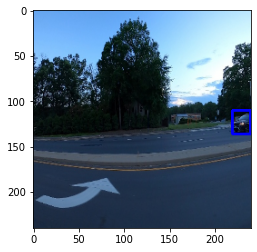

In [19]:
img, bbox = trainset[35]

xmin, ymin, xmax, ymax = bbox

pt1 = (int(xmin), int(ymin))
pt2 = (int(xmax), int(ymax))

bound_img = cv2.rectangle(img.permute(1, 2, 0).numpy(), pt1, pt2, (0, 0, 255), 2)
plt.imshow(bound_img)

In [20]:
# Dataloaders

train_loader = torch.utils.data.DataLoader(trainset, batch_size = batch_size, shuffle = True)
valid_loader = torch.utils.data.DataLoader(validset, batch_size = batch_size, shuffle = False)

In [21]:
print(f'Total no. of batches in train_loader : {len(train_loader)}')

print(f'Total no. of batches in valid_loader : {len(valid_loader)}')

Total no. of batches in train_loader : 27
Total no. of batches in valid_loader : 9


In [22]:
for images, bboxes in train_loader:
  break;


print(f'Shape of one batch images : {images.shape}')
print(f'Shape of one batch bboxes : {bboxes.shape}')

Shape of one batch images : torch.Size([16, 3, 240, 240])
Shape of one batch bboxes : torch.Size([16, 4])


In [23]:
from torch import nn
import timm



In [28]:
# Creating the Model

class ObjectDetectionModel(nn.Module):

  def __init__(self):
     super(ObjectDetectionModel, self).__init__()

     self.backbone = timm.create_model(model_name, pretrained = True, num_classes=4)

  def forward(self, images, grtruth_bboxes=None):

     bboxes = self.backbone(images)

     if grtruth_bboxes != None:
        loss = nn.MSELoss()(bboxes, grtruth_bboxes)  
        return bboxes, loss
        
     return bboxes   


In [ ]:
timm.list_models()

In [29]:
model = ObjectDetectionModel()

model.to(device)

ObjectDetectionModel(
  (backbone): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=Tr

In [30]:
random_img = torch.rand(1, 3, 140, 140).to(device)
model(random_img).shape


torch.Size([1, 4])

In [31]:
# Train func

def train_func(model, dataloader, optimizer):
  total_loss = 0.0
  model.train() # Dropout ON

  for data in tqdm(dataloader):

    images, grtruth_bboxes = data
    images, grtruth_bboxes = images.to(device), grtruth_bboxes.to(device) # switching to GPU

    bboxes, loss = model(images, grtruth_bboxes)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  return total_loss / len(dataloader)  

In [32]:
# Eval func

def eval_func(model, dataloader):
  total_loss = 0.0
  model.eval() # Dropout OFF

  with torch.no_grad():

    for data in tqdm(dataloader):

      images, grtruth_bboxes = data
      images, grtruth_bboxes = images.to(device), grtruth_bboxes.to(device) # switching to GPU

      bboxes, loss = model(images, grtruth_bboxes)



      total_loss += loss.item()

    return total_loss / len(dataloader)  

In [33]:
# Training phase

optimizer = torch.optim.Adam(model.parameters(), lr = lr)

In [34]:
best_valid_loss = np.Inf

for i in range(epochs):

  train_loss = train_func(model, train_loader, optimizer)
  valid_loss = eval_func(model, valid_loader)

  if valid_loss < best_valid_loss:
    torch.save(model.state_dict(), 'best_model.pth')
    print('weights are saved')
    best_valid_loss = valid_loss

  print(f'Epoch : {i+1} train loss : {train_loss} valid loss : {valid_loss}')  

  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

weights are saved
Epoch : 1 train loss : 1693534966.7090387 valid loss : 3529.8194173177085


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Epoch : 2 train loss : 4183.405779803241 valid loss : 3964.2322048611113


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

weights are saved
Epoch : 3 train loss : 4416.091968677662 valid loss : 3359.1049533420137


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

weights are saved
Epoch : 4 train loss : 3544.7866572627313 valid loss : 3302.4331732855903


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

weights are saved
Epoch : 5 train loss : 3521.55558042173 valid loss : 2845.456529405382


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Epoch : 6 train loss : 3435.421332465278 valid loss : 2907.917222764757


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Epoch : 7 train loss : 3809.583595558449 valid loss : 3136.121975368924


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Epoch : 8 train loss : 3298.273885091146 valid loss : 3301.8079969618057


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Epoch : 9 train loss : 3299.7977905273438 valid loss : 4294.0615234375


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Epoch : 10 train loss : 3517.5903772424767 valid loss : 2859.3546006944443


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Epoch : 11 train loss : 3857.7003038194443 valid loss : 4332.344916449652


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Epoch : 12 train loss : 3811.8715322989005 valid loss : 2847.5575358072915


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Epoch : 13 train loss : 3411.033329716435 valid loss : 3142.0643446180557


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

weights are saved
Epoch : 14 train loss : 3465.4010145399307 valid loss : 2780.945027669271


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Epoch : 15 train loss : 3582.4138997395835 valid loss : 3718.5677625868057


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Epoch : 16 train loss : 3536.546459056713 valid loss : 7026.720269097223


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Epoch : 17 train loss : 3869.5610261140046 valid loss : 2982.5524631076387


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Epoch : 18 train loss : 3862.048529730903 valid loss : 2844.0787896050347


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Epoch : 19 train loss : 3406.132477936921 valid loss : 2954.6531846788193


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Epoch : 20 train loss : 3307.629937065972 valid loss : 2786.2520616319443


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Epoch : 21 train loss : 3415.795355902778 valid loss : 3666.254828559028


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

weights are saved
Epoch : 22 train loss : 3602.580756293403 valid loss : 2686.6754692925347


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Epoch : 23 train loss : 3271.2681749131943 valid loss : 2687.8404947916665


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Epoch : 24 train loss : 3526.01501916956 valid loss : 2713.7021755642363


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Epoch : 25 train loss : 3409.9304470486113 valid loss : 2890.2529296875


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Epoch : 26 train loss : 3465.671242042824 valid loss : 2768.387925889757


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

weights are saved
Epoch : 27 train loss : 3206.3667353877313 valid loss : 2682.311754014757


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

weights are saved
Epoch : 28 train loss : 3267.657470703125 valid loss : 2667.2111002604165


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Epoch : 29 train loss : 3373.9480070891204 valid loss : 2894.169474283854


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Epoch : 30 train loss : 3284.5961100260415 valid loss : 2730.8440212673613


In [35]:
# Inference

import cv2
import numpy
import torch 

import matplotlib.pyplot as plt 

def compare_plots(image, grtruth_bbox, out_bbox):

    xmin, ymin, xmax, ymax = grtruth_bbox

    pt1 = (int(xmin), int(ymin))
    pt2 = (int(xmax), int(ymax))

    out_xmin, out_ymin, out_xmax, out_ymax = out_bbox[0]

    out_pt1 = (int(out_xmin), int(out_ymin))
    out_pt2 = (int(out_xmax), int(out_ymax))

    out_img = cv2.rectangle(image.squeeze().permute(1, 2, 0).cpu().numpy(),pt1, pt2,(0,255,0),2)
    out_img = cv2.rectangle(out_img,out_pt1, out_pt2,(255,0,0),2)
    plt.imshow(out_img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


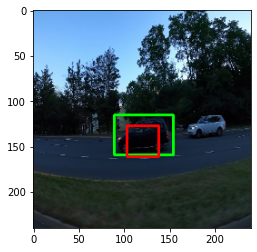

In [40]:
model.load_state_dict(torch.load('best_model.pth'))
model.eval()

with torch.no_grad():

  image, grtruth_bbox = validset[0] # (c, h, w)
  image = image.unsqueeze(0).to(device) # (b_size, c, h, w)
  out_bbox = model(image)

  compare_plots(image, grtruth_bbox, out_bbox)